#Generative Adversarial Network (GAN)
por Raziel Lopez Escamilla,

Dentro de las aplicaciones de las GAN estan la creación de imágenes, videos, música e incluso lenguajes naturales. Este tipo de redes se han empleado en tareas como traducción de imagen a imagen, súper resolución de imagen, descubrimiento de fármacos e incluso predicción del siguiente fotograma en video.

La idea clave de GAN se puede entender fácilmente considerándola análoga a la "falsificación de arte", que es el proceso de creación de obras de arte que se atribuyen falsamente a otros artistas generalmente más famosos. 

Las GAN entrenan dos redes neuronales simultáneamente, son:

*   El generador G (Z) es el que realiza la falsificación.
*   El discriminador D (Y) es el que puede juzgar cuán realistas son las 
reproducciones, basandose en observaciones de auténticas obras de arte y copias.

D (Y) toma una entrada Y (por ejemplo, una imagen) y expresa un voto para juzgar qué tan real es la entrada. 

En general, un valor cercano a 1 denota "real", mientras que un valor cercano a 0 denota "falsificación".

Por otra parte, G (Z) toma una entrada del ruido aleatorio Z y se entrena a sí mismo para engañar a D haciéndole pensar que todo lo que produce G (Z) es real.

El objetivo de entrenar el discriminador D (Y) es maximizar D (Y) para cada imagen de la verdadera distribución de datos, y para minimizar D (Y) para cada imagen que no provenga de la verdadera distribución de datos. Entonces, G y D juegan juegos opuestos: de ahí el nombre de entrenamiento adversario.

La red discriminadora (generalmente una red neuronal convolucional estándar) intenta clasificar si una imagen de entrada es real o generada. La nueva idea importante es propagar hacia atrás a través del discriminador y el generador para ajustar los parámetros del generador de tal manera que el generador pueda aprender a engañar al discriminador más a menudo.

Al final, el generador aprenderá a producir imágenes indistinguibles de las reales:

A continuacion se mostrará un ejemplo implementando una GAN con tensorflow



#GAN simple capaz de generar dígitos escritos a mano. 

Importamos librerias

In [10]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers


import matplotlib.pyplot as plt

import sys

import numpy as np
import tqdm

Se usaran los dígitos manuscritos del MNIST para entrenar la red. Los datos contienen 60.000 imágenes de entrenamiento de dígitos escritos a mano, cada uno de tamaño 28 × 28.Se normalizan los valores de entrada de modo que cada píxel tenga un valor en el rango [-1, 1].

In [11]:
# Set the seed for reproducible result
np.random.seed(1000)

randomDim = 10 
# Load MNIST data
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5



Usaremos un perceptrón multicapa simple (MLP) y lo alimentaremos con una imagen como un vector plano de tamaño 784, por lo que remodelamos los datos de entrenamiento.

In [12]:
X_train = X_train.reshape(60000, 784)

Se construye un generador y un discriminador.

In [13]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()
generator.add(Dense(256, input_dim=randomDim)) #, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784, activation='tanh'))
#generator.compile(loss='binary_crossentropy', optimizer=adam)


El propósito del generador es recibir una entrada ruidosa y generar una imagen similar al conjunto de datos de entrenamiento.

El tamaño de la entrada ruidosa lo decide la variable randomDim; puede inicializarlo a cualquier valor integral. Convencionalmente, se establece en 100. Para nuestra implementación, probamos un valor de 10. 

Esta entrada se alimenta a una capa densa con 256 neuronas con activación LeakyReLU, otra capa densa con 512 neuronas ocultas, seguida de la tercera capa oculta con 1024 neuronas y finalmente la capa de salida con 784 neuronas. 

Es posible cambiar el número de neuronas en las capas ocultas y ver cómo cambia el rendimiento; sin embargo, el número de neuronas en la unidad de salida tiene que coincidir con el número de píxeles en las imágenes de entrenamiento. 

Construimos un discriminador.

In [14]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

Observe que el discriminador toma las imágenes, ya sea del conjunto de entrenamiento o imágenes generadas por el generador, por lo que su tamaño de entrada es 784. Sin embargo, la salida del discriminador es un solo bit, donde 0 significa una imagen falsa (generada por el generador) y 1 significa que la imagen es del conjunto de datos de entrenamiento.

Combinamos el generador y el discriminador para formar un GAN. 

En GAN, nos aseguramos de que los pesos del discriminador se fijen estableciendo el argumento entrenable en Falso.

In [15]:
# Combined network
discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []


Se calculan las perdidas y se genera una ruta para poder ingresar a MNIST y obtener la imagen.



In [16]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('Images_GAN_Genera_%d.png' % epoch)

# Create a wall of generated MNIST images
def saveGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('imagenes_loss_gan_%d.png' % epoch)

Se realiza entrenamiento.

Para cada época, se toma primero una muestra de ruido aleatorio, se alimenta al generador y el generador produce una imagen falsa. 

Se combinan las imágenes falsas generadas y las imágenes de entrenamiento reales en un lote con sus etiquetas específicas y se usan para entrenar al discriminador primero en el lote dado.

In [17]:
def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print ('Epochs:', epochs)
    print ('Batch size:', batchSize)
    print ('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)

        if e == 1 or e % 20 == 0:
            saveGeneratedImages(e)
            

    # Plot losses from every epoch
    plotLoss(e)

Epochs: 15
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------
--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------
--------------- Epoch 10 ---------------
--------------- Epoch 11 ---------------
--------------- Epoch 12 ---------------
--------------- Epoch 13 ---------------
--------------- Epoch 14 ---------------
--------------- Epoch 15 ---------------


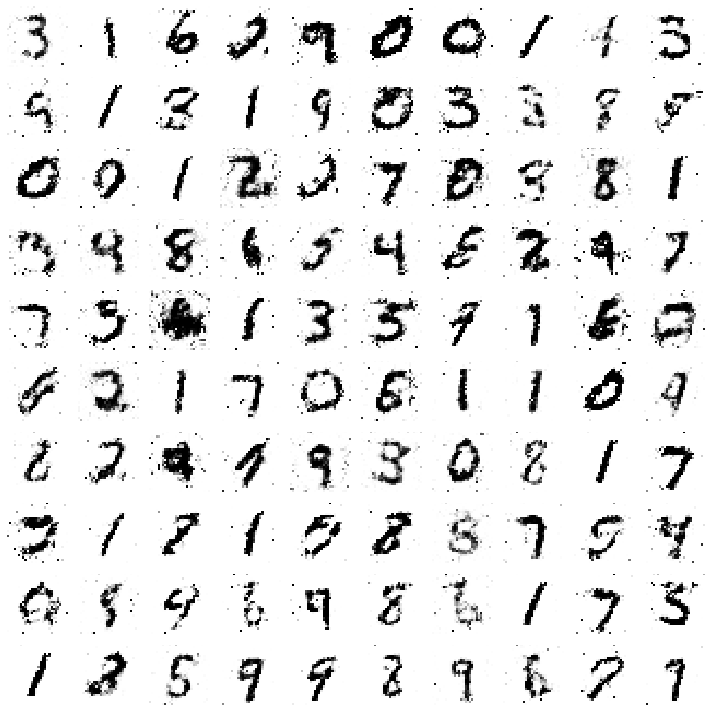

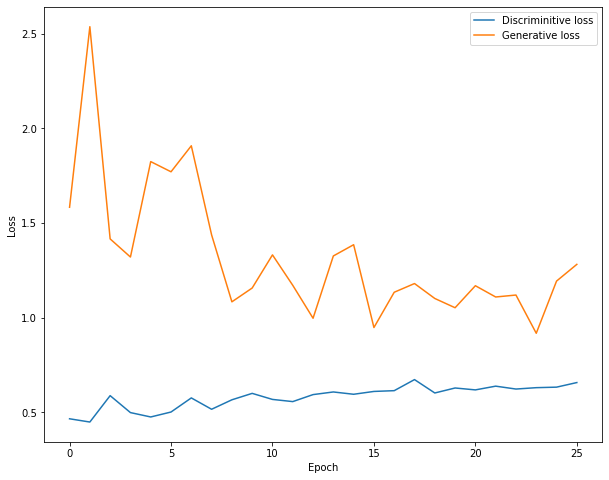

In [19]:
train(15, 128)

Conclusión:

Por lo aprendido en este ejercicio GAN nos pueden ayudar a gener copias similares en estilo o forma a partir de información original, en el ejemplo aterior se necesitó de mucho entrenamiento para poder generar resultados aceptables para un humano. Actualmente, dentro del área de imagenes, las GAN han sido utilizadas para generar imagenes falsas de animales, paisajes, rostros humanos, etc.